In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F 
from torchvision import datasets, transforms
import os

print(torch.__version__)

2.5.1


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device = ",device)

Using device =  cpu


In [3]:
# Define dataset paths
train_dir = "CustomDataSet/data/train"
test_dir = "CustomDataSet/data/test"

In [4]:
# Define train and test transforms
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

In [5]:
# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [6]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
from model import CustomCNN

In [8]:
model_0 = CustomCNN(num_classes=4)
model_0.to(device)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [9]:
class_names = train_data.classes
class_names

['donuts', 'french_fries', 'fried_rice', 'samosa']

In [10]:
class_dict = train_data.class_to_idx
class_dict

{'donuts': 0, 'french_fries': 1, 'fried_rice': 2, 'samosa': 3}

In [11]:
len(train_data), len(test_data)

(1834, 608)

In [12]:
from torchinfo import summary

summary(model=model_0,
        input_size=(32,3,128,128),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomCNN (CustomCNN)                    [32, 3, 128, 128]    [32, 4]              --                   True
├─Conv2d (conv1)                         [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
├─ReLU (relu)                            [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
├─MaxPool2d (pool)                       [32, 32, 128, 128]   [32, 32, 64, 64]     --                   --
├─Conv2d (conv2)                         [32, 32, 64, 64]     [32, 64, 64, 64]     18,496               True
├─ReLU (relu)                            [32, 64, 64, 64]     [32, 64, 64, 64]     --                   --
├─MaxPool2d (pool)                       [32, 64, 64, 64]     [32, 64, 32, 32]     --                   --
├─Conv2d (conv3)                         [32, 64, 32, 32]     [32, 128, 32, 32]    73,856               True
├─ReLU (relu)         

In [13]:
# Setup loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=1e-4)

In [14]:
from trainNN import train

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = train(
            model=model_0,
            train_dataloader=train_loader,
            test_dataloader=test_loader,
            optimizer=optimizer,
            loss_fn=criterion,
            epochs=10,
            device=device
)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3757 | train_acc: 0.3154 | test_loss: 1.2932 | test_acc: 0.3651
Epoch: 2 | train_loss: 1.2797 | train_acc: 0.3881 | test_loss: 1.1940 | test_acc: 0.4589
Epoch: 3 | train_loss: 1.2501 | train_acc: 0.4115 | test_loss: 1.1734 | test_acc: 0.4737
Epoch: 4 | train_loss: 1.2279 | train_acc: 0.4390 | test_loss: 1.1411 | test_acc: 0.5148
Epoch: 5 | train_loss: 1.2017 | train_acc: 0.4497 | test_loss: 1.1333 | test_acc: 0.5000
Epoch: 6 | train_loss: 1.1947 | train_acc: 0.4526 | test_loss: 1.1007 | test_acc: 0.5477
Epoch: 7 | train_loss: 1.1564 | train_acc: 0.4898 | test_loss: 1.0619 | test_acc: 0.5559
Epoch: 8 | train_loss: 1.1380 | train_acc: 0.4947 | test_loss: 1.0820 | test_acc: 0.5197
Epoch: 9 | train_loss: 1.0887 | train_acc: 0.5270 | test_loss: 0.9691 | test_acc: 0.6135
Epoch: 10 | train_loss: 1.0582 | train_acc: 0.5597 | test_loss: 0.9800 | test_acc: 0.5921
[INFO] Total training time: 512.834 seconds


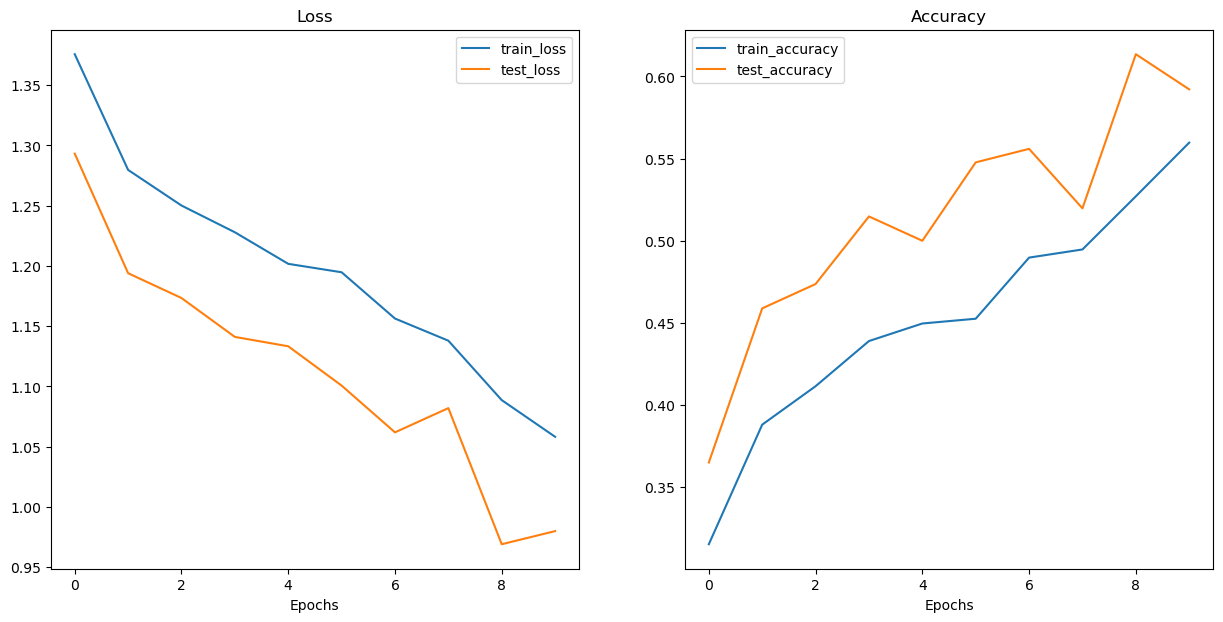

In [15]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [16]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "modelv0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\modelv0.pth
